Calculate inprop for optic lobe neurons on the right hemisphere of FAFB on a signle neuron level. Cell classes of 'optic', 'visual_projection', and 'visual_centrifugal' are kept. 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

# reading data

In [2]:
info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',
                   delimiter = '\t')
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_61764\649695127.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [3]:
info.super_class.value_counts(dropna = False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [4]:
optic = info[info.super_class.isin(
    ['visual_projection', 'visual_centrifugal', 'optic'])]

In [5]:
# where are the cell types? 
optic[['cell_type','hemibrain_type']].isna().value_counts()

cell_type  hemibrain_type
False      True              72669
True       True               6129
           False              4039
False      False              3276
Name: count, dtype: int64

In [6]:
# around 3k with both cell_type and hemibrain_type - do they correspond to each other? 
optic[~optic.cell_type.isna() & ~optic.hemibrain_type.isna()][['cell_type','hemibrain_type']].value_counts()

cell_type  hemibrain_type             
MeTu4      MC61,MC64                      278
MeTu3      MC61,MC64                      274
MeTu1      MC61,MC64                      244
LLPC2      LLPC2a,LLPC2b,LLPC2c,LLPC2d    235
LC10a      LC10                           234
                                         ... 
MeLp1      5813068976                       2
LCe01b     LC25                             1
           LC25,LC26                        1
LCe01a     LC25,LC26                        1
LCe02      LC25                             1
Name: count, Length: 209, dtype: int64

In [7]:
# since hemibrain is truncated, let's prioritize cell_type
optic.loc[:,['combined_type']] = optic.cell_type
# fill the leftover nas with hemibrain_type 
optic.combined_type.fillna(optic.hemibrain_type, inplace = True)
# then fill the rest with root ids 
optic.combined_type.fillna(optic.root_id.astype(str), inplace = True)

C:\Users\44745\AppData\Local\Temp\ipykernel_61764\2303128075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optic.combined_type.fillna(optic.hemibrain_type, inplace = True)
C:\Users\44745\AppData\Local\Temp\ipykernel_61764\2303128075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optic.combined_type.fillna(optic.root_id.astype(str), inplace = True)


In [8]:
# make dictionaries to map between columns 
typedict = dict(zip(optic.root_id, optic.combined_type))
sidedict = dict(zip(optic.root_id, optic.side))
type_super_class_dict = dict(zip(optic.combined_type, optic.super_class))
type_class_dict = dict(zip(optic.combined_type, optic.cell_class)) 
type_sub_class_dict = dict(zip(optic.combined_type, optic.cell_sub_class))

## read connectivity

In [9]:
import platform 

if platform.system() == 'Windows': 
    # using updated connectivity from Sven 
    conn_full = pd.read_feather(
        'C:/Users/44745/Downloads/syn_proof_analysis_filtered_consolidated_ntavg_783.feather')
else: 
    conn_full = pd.read_feather('/Users/yijieyin/Downloads/syn_proof_analysis_filtered_consolidated_783.feather')

conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


# NT

In [10]:
optic.top_nt.value_counts(dropna = False)

top_nt
acetylcholine    58391
glutamate        14397
gaba             13078
serotonin          109
dopamine            49
NaN                 47
octopamine          42
Name: count, dtype: int64

In [11]:
optic.known_nt.unique()

array([nan, 'acetylcholine', 'glutamate, Dh44, allatostatin-c',
       'octopamine', 'glycine, pdf', 'ion-transport peptide', 'glycine',
       'glycine, pdf, sNPF', 'gaba', 'serotonin', 'dopamine', 'glutamate',
       'acetylcholine, allatostatin-a', 'gaba, nitric oxide',
       'acetylcholine, nitric oxide', 'glutamate, gaba',
       'gaba, nitric oxide, allatostatin-c',
       'acetylcholine, nitric oxide, dopamine',
       'acetylcholine, allatostatin-c'], dtype=object)

In [12]:
# known_nt takes priority 
optic['known_nt_simplified'] = optic.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
optic.known_nt_simplified = optic.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
optic.known_nt_simplified.value_counts(dropna = False)

# then use this column to replace values in top_nt column 
optic.top_nt = optic.known_nt_simplified.fillna(optic.top_nt)

C:\Users\44745\AppData\Local\Temp\ipykernel_61764\3640933435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optic['known_nt_simplified'] = optic.known_nt
C:\Users\44745\AppData\Local\Temp\ipykernel_61764\3640933435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optic.known_nt_simplified = optic.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
C:\Users\44745\AppData\Local\Temp\ipykernel_61764\3640933435.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

C:\Users\44745\AppData\Local\Temp\ipykernel_61764\1437609657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optic['top_nt'] = optic['top_nt'].fillna('unknown')


(array([6.637e+03, 5.900e+01, 0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

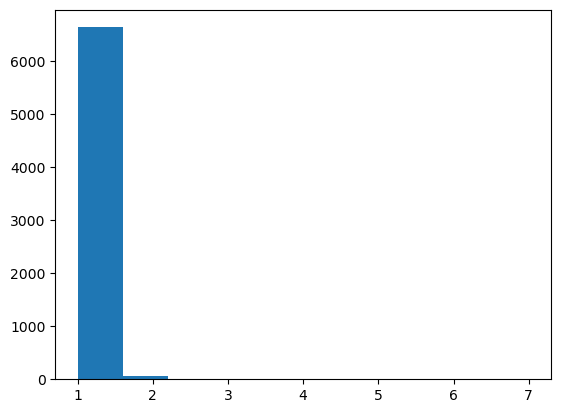

In [13]:
# first check consistency of NT within each type 
optic['top_nt'] = optic['top_nt'].fillna('unknown')
nt_count_per_type = optic.groupby('combined_type')['top_nt'].nunique()
plt.hist(nt_count_per_type)

In [14]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = optic[optic.combined_type.isin(nt_conflict_types)].groupby(['combined_type', 'top_nt']).size()

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name='counts')

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(by=['combined_type', 'counts'], ascending=[True, False], inplace=True)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(optic.combined_type, optic.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []

# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df['counts'].max()
    top_nts = df[df['counts'] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(df['combined_type'].iloc[0])  # Record the type with ties
        random_nt = np.random.choice(top_nts['top_nt'].values)
        while random_nt == 'unknown': 
            random_nt = np.random.choice(top_nts['top_nt'].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts['top_nt'].values[0]

# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts['combined_type'] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

7

In [15]:
# the types without any known nt 
[atype for atype, nt in type_nt.items() if nt == 'unknown']

['720575940610585442',
 '720575940627099934',
 '720575940628125416',
 '720575940623372502',
 '720575940629569040',
 '720575940625998895',
 '720575940617649238']

In [16]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary 
nt_value = {'acetylcholine': 1, 
           'glutamate': -1, 
           'gaba': -1, 
           'dopamine': 1, 
           'serotonin': 1, 
           'octopamine': 1, 
           'unknown': 1}

# make coo

In [17]:
rhs_visual = set(optic.root_id[optic.side == 'right'])
# keep connections between RHS visual neurons (optic, visual_projection, visual_centrifugal); 
conn = conn_full[(conn_full.pre_pt_root_id.isin(rhs_visual) & conn_full.post_pt_root_id.isin(rhs_visual)) | 
            # and those upstream of RHS 'optic' neurons, in the RHS neuropils  
            ((conn_full.post_pt_root_id.isin(optic.root_id[(optic.super_class == 'optic') & (optic.side == 'right')])) & (conn_full.neuropil.str.contains('_R$')))]
# keep in mind that no neuron here is guaranteed to have all their upstream partners in conn

# sym synapse numbers across neuropils
conn = conn.groupby(['pre_pt_root_id', 'post_pt_root_id']
                    ).syn_count.sum().reset_index()
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940596125868,720575940605825666,2
1,720575940596125868,720575940606217138,1
2,720575940596125868,720575940608552405,5
3,720575940596125868,720575940609975854,4
4,720575940596125868,720575940613059993,5
...,...,...,...
4533223,720575940661327745,720575940641188304,1
4533224,720575940661327745,720575940643231117,2
4533225,720575940661327745,720575940654273185,1
4533226,720575940661339777,720575940616982614,4


In [18]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(conn.pre_pt_root_id).union(set(conn.post_pt_root_id))
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node:num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn['pre_idx'] = conn.pre_pt_root_id.map(nodes_to_idx) 
conn['post_idx'] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn['pre_idx'].values
col = conn['post_idx'].values
data = conn['syn_count'].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size/1e6

54.591384

In [19]:
csc.shape

(48161, 48161)

In [20]:
csc

<48161x48161 sparse matrix of type '<class 'numpy.int64'>'
	with 4533228 stored elements in Compressed Sparse Column format>

In [21]:
# calculate the total post-synapses for each neuron 
total_post = conn_full[conn_full.post_pt_root_id.isin(nodes)].groupby('post_pt_root_id').syn_count.sum()

# some neurons have no postsynapses (receptors). Let's add those to total_post with value of 0
no_post = nodes - set(total_post.index)
no_post_dict = dict(zip(no_post, np.zeros(len(no_post), dtype=int)))
total_post = pd.concat([total_post, pd.Series(no_post_dict)])
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940635647935      0
720575940621225921      0
720575940634367970      0
720575940625410028      0
720575940642117621      0
Length: 48161, dtype: int64

In [22]:
# re-order so that it matches order of nodes 
total_post = total_post.loc[sorted_nodes]
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940661318017    496
720575940661320065    225
720575940661325697    765
720575940661327745    227
720575940661339777      2
Length: 48161, dtype: int64

In [23]:
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
col_sums_with_inversion = np.reciprocal(
    total_post.to_numpy().astype(float), where=total_post.to_numpy() != 0)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

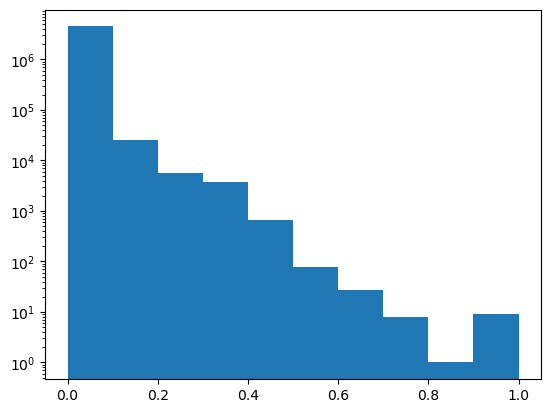

In [24]:
# histogram of connection strengths 
plt.hist(inprop.data)
plt.yscale('log')
plt.show()

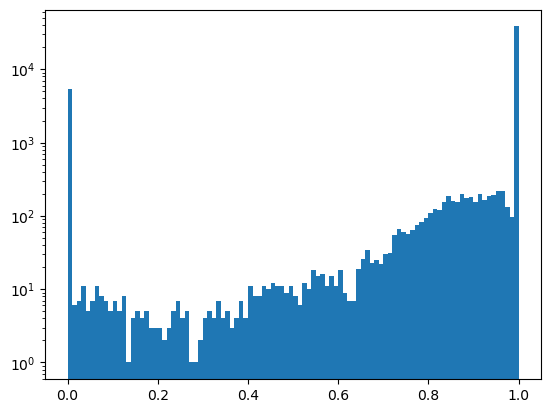

In [25]:
# histogram of column sums 
colsums = inprop.sum(axis=0)
plt.hist(colsums.A1, bins = 100)
plt.yscale('log')
plt.show()

In [26]:
# how many colsums are around 1?
np.sum(colsums > 0.99)

38416

In [27]:
sp.sparse.save_npz('data/fafb_inprop_optic_right_neuron.npz', inprop)

In [28]:
# save to csv, one row is one neuron 
meta = optic[['root_id', 'combined_type', 'side', 'top_nt', 'super_class',
           'cell_class', 'cell_sub_class', 'ito_lee_hemilineage', 'hartenstein_hemilineage']]
meta.loc[:,['idx']] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ['sign']] = meta.top_nt.map(nt_value)
meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)

# adult, right hemisphere, neuron level, meta information 
meta.to_csv('data/fafb_optic_right_neuron_meta.csv')

C:\Users\44745\AppData\Local\Temp\ipykernel_61764\992757239.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)


In [29]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,ito_lee_hemilineage,hartenstein_hemilineage,idx,sign
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,NaN,NaN,38775.0,1
5,720575940638709326,LTe07,right,glutamate,visual_projection,NaN,NaN,NaN,NaN,43407.0,-1
6,720575940614754797,MTe12,right,acetylcholine,visual_projection,NaN,NaN,NaN,NaN,7313.0,1
7,720575940622660490,MTe04,right,glutamate,visual_projection,NaN,NaN,NaN,NaN,19408.0,-1
8,720575940659799937,VS4,right,acetylcholine,visual_projection,NaN,NaN,putative_primary,putative_primary,48012.0,1
...,...,...,...,...,...,...,...,...,...,...,...
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,NaN,NaN,12254.0,1
139251,720575940633170572,CB3823,right,acetylcholine,optic,LO,NaN,NaN,NaN,38493.0,1
139252,720575940650339961,CB3848,right,acetylcholine,optic,LO,NaN,NaN,NaN,47512.0,1
139253,720575940619997854,720575940619997854,left,acetylcholine,optic,ME>LO,NaN,NaN,NaN,NaN,1
